# Reconstruction of plant--pollinator networks from observational data 

In this notebook, we reproduce the Bayesian model introduced in the paper [*"Reconstruction of plant--pollinator networks from observational data"*](https://www.biorxiv.org/content/10.1101/754077v1), by [J.-G. Young](http://jgyoung.ca), [F. S. Valdovinos](https://www.fsvaldovinos.com/) and [M.E.J. Newman](http://www-personal.umich.edu/~mejn/). The model infers the underlying structure of a plant–pollinator network from observational data—specifically, from the number of visits observed between different plant and pollinator species.

Rather than relying only on raw counts, this approach treats the data as samples from a hidden interaction structure, accounting for species’ abundances, observation effort, and the possibility of preferred interactions. The model uses a Poisson distribution to describe visit counts and a Bayesian framework to infer the most likely structure and parameters. This allows us not only to estimate who interacts with whom, but also to quantify uncertainty and test model fit using simulated data.

Goal of the Model

We want to understand the true ecological network: which pollinators actually interact with which plants, even if some interactions were missed or under-sampled. Instead of taking the visit counts at face value, we ask:

“What underlying network structure would most likely explain the visits we observed?” 

*Authors*: Hugo Gorbato Souto and Tatiana Farane Mein
*Date*: May 2024

---

**Important Note:** In this notebook, we assume that `pystan` has been installed and will interact with the model in `python3`. `Stan` also has a [R interface](https://cran.r-project.org/web/packages/rstan/index.html), for which we do not provide helper functions.
That said, all what we show here should easily be transferable to the `R` version of `Stan`!
The only purpose of our python code is to manipulate the samples once they have been generated by `Stan`.

---

## Loading data and modules

### Importing Required Libraries

First, we import the essential modules required to build and run the Bayesian inference model, manipulate data, and generate visualizations:

- `pystan` is used to compile and fit the Bayesian model.  
- `numpy` is used for numerical operations and array manipulation.  
- `pandas` provides data structures (such as DataFrames) that facilitate the inspection, organization, and manipulation of tabular data.  
- `matplotlib.pyplot` is used to visualize the data and the results of the inference process.  
- `%matplotlib inline` ensures that plots are rendered directly within the notebook.

We also import two project-specific helper modules that streamline key aspects of the workflow:

- `utilities`: provides utility functions for loading, saving, compressing, and organizing visitation data matrices.  
- `plant_pol_inference`: contains functions for compiling the Stan model, drawing posterior samples, and computing derived estimates and diagnostics.

Together, these modules support a structured and reproducible analysis pipeline for ecological network reconstruction.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import utilities as ut
import plant_pol_inference as pp

In [2]:
import pandas as pd

INFO:numexpr.utils:Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.


### Loading the Empirical Interaction Matrix

In this section, we load the empirical visitation matrix that will serve as input for our network reconstruction model. The data come from the supplementary material of the study by Kaiser-Bunbury et al. ([Nature **542**, 2017](https://www.nature.com/articles/nature21071)). The matrix records the number of interactions between 8 plant species and 21 pollinator species in a single ecosystem, observed over the course of one month.

In [3]:
M=pd.read_csv("M_PL_019_matrix.csv",index_col="Plant")

In [4]:
M=np.array(M)

In [5]:
M = ut.sort(M, M)
n_p = M.shape[0]
n_a = M.shape[1]

In [6]:
n_p

40

In [7]:
n_a

85

### Visualizing the Raw Interaction Matrix

Figure 1a displays the raw interaction data used as the input for the Bayesian reconstruction model. This matrix, denoted as $ M $, encodes the number of observed interactions between plant species (rows) and pollinator species (columns). Each element $ M_{ij} $ ideally represents the number of times pollinator $ j $ was observed visiting plant $ i $ during a defined sampling period, such as one month at the "Trois Frères" site in the original study by Kaiser-Bunbury et al. (Nature **542**, 2017).

However, the version of the dataset used here—sourced from the Web of Life database (network ID `M_PL_019`)—does not support filtering by site or time via the public API. As a result, the matrix shown is aggregated across multiple locations and time points. Consequently, the species composition and interaction frequencies may differ from those shown in Figure 1a of the original paper.

In the visualization:

- **Darker squares** indicate a greater number of observed visits between a species pair, representing stronger observed interaction frequency.  
- **White squares** correspond to $ M_{ij} = 0 $, meaning no visits were recorded between plant $ i $ and pollinator $ j $.  
- **Rows and columns are sorted** by total interaction counts, placing the most active species toward the top and left, which helps reveal the structure of the core network.

This matrix forms the starting point for the modeling process. However, empirical ecological data are often noisy and incomplete—interactions may go unobserved due to limited sampling, rare species, or temporal mismatches. The goal of the Bayesian approach is to infer the latent, underlying network structure by estimating the probability of each potential interaction, even when $ M_{ij} = 0 $ in the data.


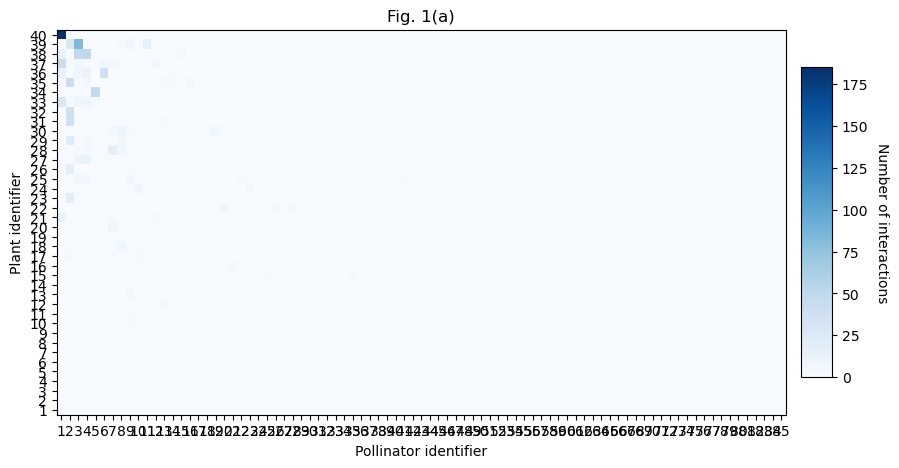

In [9]:
plt.figure(figsize=(10,5))
plt.pcolormesh(M, cmap=plt.cm.Blues)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Number of interactions', rotation=270)
plt.title("Fig. 1(a)")
plt.yticks(np.array(range(n_p)) + 0.5, range(1, n_p + 1))
plt.xticks(np.array(range(n_a)) + 0.5, range(1, n_a + 1))
plt.xlabel('Pollinator identifier')
plt.ylabel('Plant identifier')
plt.show()

## Pystan model

In `pystan`, we write the statistical model in a separate file.
In our case, it looks like:

In [8]:
with open('model.stan', 'r') as f:
    print(f.read())

data {
  // Dimensions of the data matrix, and matrix itself.
  int<lower=1> n_p;
  int<lower=1> n_a;
  int<lower=0> M[n_p, n_a];
}
transformed data {
  // Pre-compute the marginals of M to save computation in the model loop.
  int M_rows[n_p] = rep_array(0, n_p);
  int M_cols[n_a] = rep_array(0, n_a);
  int M_tot = 0;
  for (i in 1:n_p) {
    for (j in 1:n_a) {
      M_rows[i] += M[i, j];
      M_cols[j] += M[i, j];
      M_tot += M[i, j];
    }
  }
}
parameters {
  real<lower=0> C;
  real<lower=0> r;
  simplex[n_p] sigma;
  simplex[n_a] tau;
  real<lower=0, upper=1> rho;
}
model {
  // Global sums and parameters
  target += M_tot * log(C) - C;
  // Weighted marginals of the data matrix 
  for (i in 1:n_p) {
    target += M_rows[i] * log(sigma[i]);
  }
  for (j in 1:n_a) {
    target += M_cols[j] * log(tau[j]);
  }
  // Pairwise loop
  for (i in 1:n_p) {
    for (j in 1:n_a) {
      real nu_ij_0 = log(1 - rho);
      real nu_ij_1 = log(rho) + M[i,j] * log(1 + r) - C * r * sigma[i] * t

The `data` block contains the model parameters, in our case the dimension of the observation matrix, and the matrix itself.

The `transformed data` block allows us to calculate quantities that we'll use later. Here, we calculate the row and column sums of M, as well as its total sum.

The `parameter` block contains the parameters of the model.
These parameters are the ones that will be sampled by `Stan`, and returned to us  once we run the program.
`sigma` and `tau` are of the "simplex" type---just a synonym for normalized distributions.

The `model` block calculates the log-posterior of the model. We accumulate this value in the variable `target`.

The `generated quantities` block contains other quantities, functions of the sampled parameters, that will be returned to us once we run the program. In this case, we generate the matrix Q of edge probabilities given the parameters.

---

## Compiling the model

To  start using the model, we first need to "compile" it.
During compilation, `pystan` builds an executable whose purpose is to generate samples from our model, given an input.
Compilation takes a bit of time, but we only need to compile the model once. We are free to re-use it as many times as we like afterwards.

Our module `plant_pol_inference` (imported as `pp`) provides utilities to handle this.

In [9]:
model = pp.load_model()

c:\Users\hugog\Desktop\Master_Courses\Complex_Networks\Project\projeto\model.bin [Skipping --- already compiled]


## Sampling

With the model compiled, we are ready to generate our first samples.

Our `plant_pol_inference` module also provide utilities that handle this.

In [14]:
samples = pp.generate_sample(M, model, warmup=2000, num_samples=500)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


The warnings above indicate that at least one chain has gotten stuck in a minima.

We can see this by plotting the value of the posterior distribution, evaluated for each samples.

Note that in this plot, vertical lines separate Markov chains: All samples between two of these lines are generated sequentially, by an independent chain.

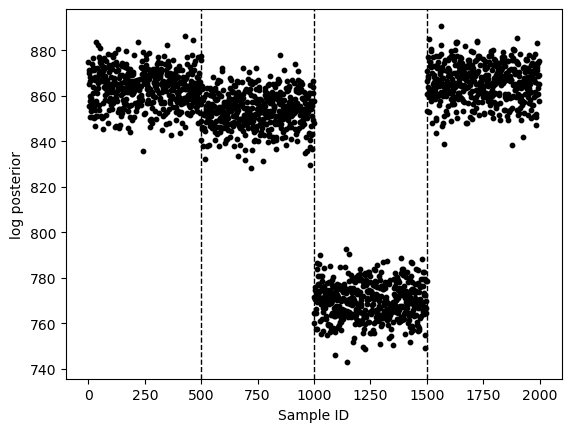

In [15]:
plt.scatter(range(2000), samples['lp__'], s=10, c='k')
for sep in [500, 1000, 1500]:
    plt.axvline(sep, c='k', ls='--', lw=1)
plt.xlabel('Sample ID')
plt.ylabel('log posterior')
plt.show()

In this particular case, the third chain got stuck in an optima with lower posterior probability.

We re-run the sampling until we get a clean sample:

In [16]:
while not pp.test_samples(samples, tol=0.05):
    samples = pp.generate_sample(M, model, warmup=2000, num_samples=500)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


After a few attempt we find a nice set of samples:

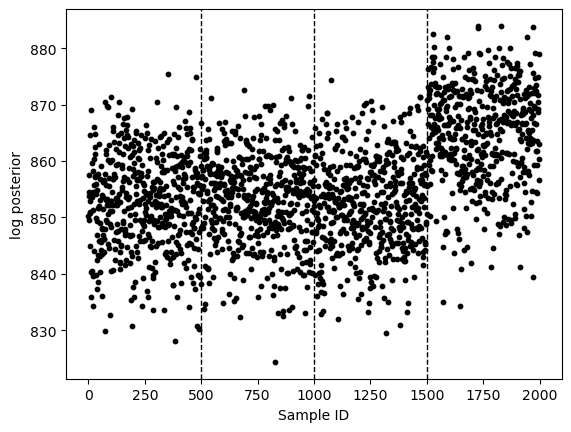

In [17]:
plt.scatter(range(2000), samples['lp__'], s=10, c='k')
for sep in [500, 1000, 1500]:
    plt.axvline(sep, c='k', ls='--', lw=1)
plt.xlabel('Sample ID')
plt.ylabel('log posterior')
plt.show()

Though one could still affirm that the third chain is still stuck, this could be an optical illusion as the y-axis does not start from 0. Given the diagnostic graphs found later in this notebook, we believe that the chains reached their global optima.

The following is a summary of our succesful sampling procedure:

In [18]:
samples


For the full summary use 'print(fit)'

Inference for Stan model: plant_pol_e215d9f28a31a5a7790444e1b0d7f7ff.
4 chains, each with iter=2500; warmup=2000; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
C          205.1     nan  24.98 160.03 187.89  203.0 222.01 258.54    nan    nan
r          59.62     nan   7.81  47.02  54.05  58.91  64.24  77.76    nan    nan
sigma[1]  3.7e-3     nan 3.3e-3 3.4e-4 1.5e-3 2.8e-3 4.9e-3   0.01    nan    nan
sigma[2]  3.3e-3     nan 2.8e-3 3.2e-4 1.3e-3 2.5e-3 4.5e-3   0.01    nan    nan
sigma[3]  3.1e-3     nan 3.0e-3 2.6e-4 1.2e-3 2.3e-3 4.1e-3   0.01    nan    nan
sigma[4]  3.0e-3     nan 2.7e-3 2.9e-4 1.2e-3 2.2e-3 3.8e-3 9.7e-3    nan    nan
sigma[5]  5.4e-3     nan 3.8e-3 8.3e-4 2.8e-3 4.6e-3 7.0e-3   0.02    nan    nan
sigma[6]  5.5e-3     nan 4.0e-3 8.5e-4 2.7e-3 4.4e-3 7.4e-3   0.02    nan    nan
sigma[7]  2.5e-3     nan 2.2e-3 4.4e-4 1.3e-

In [ ]:
#Saving the model
import pickle
filename = 'stan_model_fit.pkl'
try:
    with open(filename, 'wb') as f:
        pickle.dump(samples, f)
    print(f"Stan fit object successfully saved to {filename}")
except Exception as e:
    print(f"Error saving fit object: {e}")

C:\Users\hugog\AppData\Local\Temp\ipykernel_4424\55626725.py:7: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump(fit, f)


Stan fit object successfully saved to stan_model_fit.pkl


In [10]:
import pickle
filename = 'stan_model_fit.pkl'

samples = None
try:
    with open(filename, 'rb') as f:
        samples = pickle.load(f)
    print(f"Stan fit object successfully loaded from {filename}")

except FileNotFoundError:
    print(f"Error loading fit object: File not found at {filename}")
except Exception as e:
    print(f"Error loading fit object: {e}")


Stan fit object successfully loaded from stan_model_fit.pkl


In [13]:
samples


For the full summary use 'print(fit)'

Inference for Stan model: plant_pol_e215d9f28a31a5a7790444e1b0d7f7ff.
4 chains, each with iter=2500; warmup=2000; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
C          205.1     nan  24.98 160.03 187.89  203.0 222.01 258.54    nan    nan
r          59.62     nan   7.81  47.02  54.05  58.91  64.24  77.76    nan    nan
sigma[1]  3.7e-3     nan 3.3e-3 3.4e-4 1.5e-3 2.8e-3 4.9e-3   0.01    nan    nan
sigma[2]  3.3e-3     nan 2.8e-3 3.2e-4 1.3e-3 2.5e-3 4.5e-3   0.01    nan    nan
sigma[3]  3.1e-3     nan 3.0e-3 2.6e-4 1.2e-3 2.3e-3 4.1e-3   0.01    nan    nan
sigma[4]  3.0e-3     nan 2.7e-3 2.9e-4 1.2e-3 2.2e-3 3.8e-3 9.7e-3    nan    nan
sigma[5]  5.4e-3     nan 3.8e-3 8.3e-4 2.8e-3 4.6e-3 7.0e-3   0.02    nan    nan
sigma[6]  5.5e-3     nan 4.0e-3 8.5e-4 2.7e-3 4.4e-3 7.4e-3   0.02    nan    nan
sigma[7]  2.5e-3     nan 2.2e-3 4.4e-4 1.3e-

With a representative set of posterior samples obtained, we now proceed to model checking and estimation.

## Posterior-predictive check

We provide a simple function that calculates the posterior predictive matrix.

In [12]:
def get_posteriors_predictive_matrices(samples):
    """Calculate the posterior predictive matrix."""
    Q = samples['Q']
    C = samples['C']
    r = samples['r']
    ones = np.ones((len(samples['lp__']), Q.shape[1], Q.shape[2]))
    sigma_tau = np.einsum('ki,kj->kij', samples['sigma'], samples['tau'])
    accu = (1 - Q) * np.einsum('kij,k->kij', ones, C) * sigma_tau
    accu += Q * np.einsum('kij,k->kij', ones, C * (1 + r)) * sigma_tau
    return accu

In [13]:
M_tilde = pp.get_posterior_predictive_matrix(samples)
posterior_samples = get_posteriors_predictive_matrices(samples)

In [16]:
# Calculate the 97.5th percentile along the first axis (axis=0)
upper_bound_matrix = np.percentile(posterior_samples, 97.5, axis=0)

# Calculate the 2.5th percentile along the first axis (axis=0)
lower_bound_matrix = np.percentile(posterior_samples, 2.5, axis=0)


We can now compare it with the input.

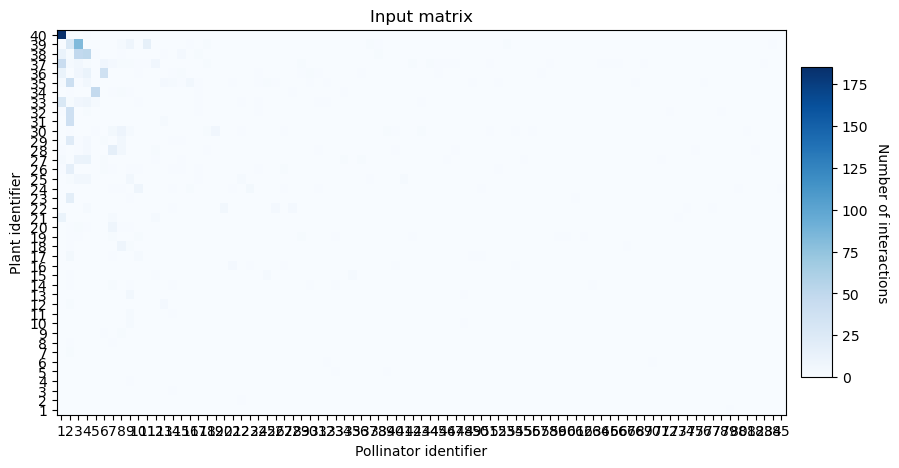

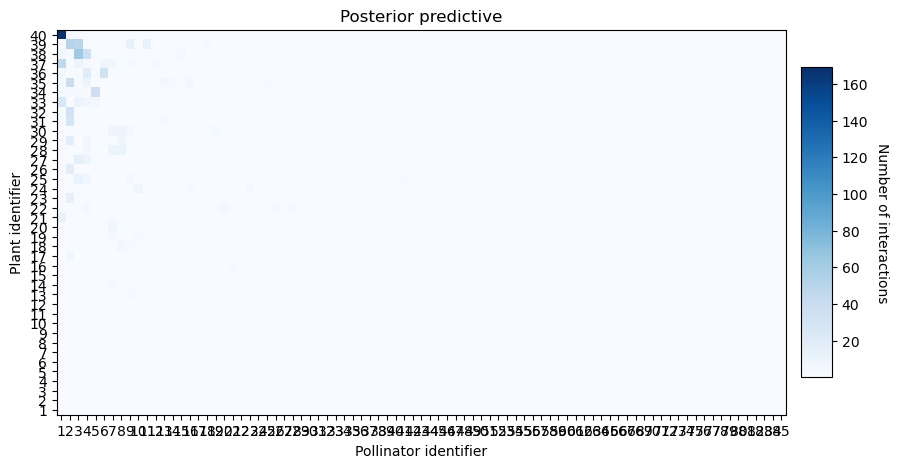

In [18]:
plt.figure(figsize=(10,5))
plt.title('Input matrix')
plt.pcolormesh(M, cmap=plt.cm.Blues)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Number of interactions', rotation=270)
plt.yticks(np.array(range(n_p)) + 0.5, range(1, n_p + 1))
plt.xticks(np.array(range(n_a)) + 0.5, range(1, n_a + 1))
plt.xlabel('Pollinator identifier')
plt.ylabel('Plant identifier')
plt.figure(figsize=(10,5))
plt.title('Posterior predictive')
plt.pcolormesh(M_tilde, cmap=plt.cm.Blues)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Number of interactions', rotation=270)
plt.yticks(np.array(range(n_p)) + 0.5, range(1, n_p + 1))
plt.xticks(np.array(range(n_a)) + 0.5, range(1, n_a + 1))
plt.xlabel('Pollinator identifier')
plt.ylabel('Plant identifier')
plt.show()


They are quite close!

More systematically we can check the distribution of the differences between the posterior predictive and the input:

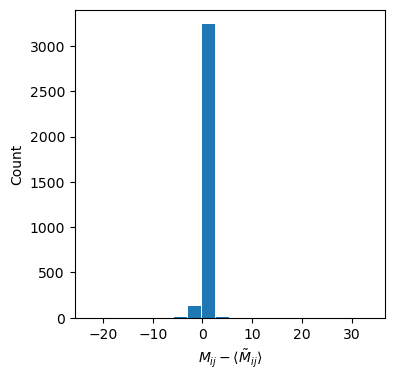

In [19]:
plt.figure(figsize=(4,4))
plt.hist((M-M_tilde).flatten(), density=False, bins=20, rwidth=0.9);

plt.xlabel(r'$M_{ij}-\langle \tilde{M}_{ij}\rangle$')
plt.ylabel('Count')
plt.show()

Or compare the posterior predictive value to the input directly:

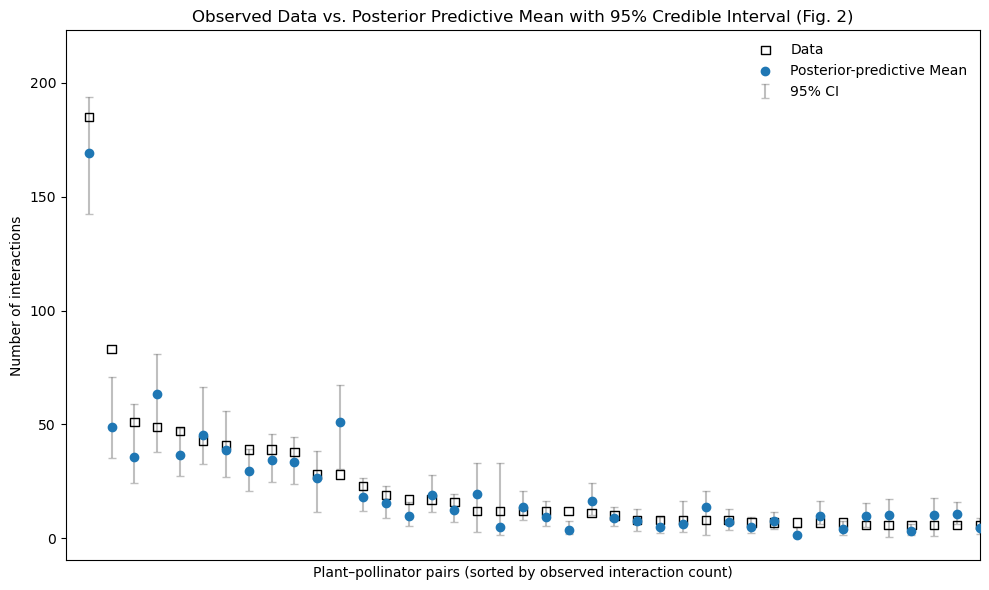

In [20]:
plt.figure(figsize=(10, 6)) 
sort_order = np.argsort(-M.flatten()) 

M_flat_sorted = M.flatten()[sort_order]
M_tilde_mean_flat_sorted = M_tilde.flatten()[sort_order]
lower_bounds_flat_sorted = lower_bound_matrix.flatten()[sort_order]
upper_bounds_flat_sorted = upper_bound_matrix.flatten()[sort_order]

lower_errors = M_tilde_mean_flat_sorted - lower_bounds_flat_sorted
upper_errors = upper_bounds_flat_sorted - M_tilde_mean_flat_sorted
yerr_values = [lower_errors, upper_errors]

x_values = range(1, len(sort_order) + 1)


plt.scatter(x_values, M_flat_sorted, marker='s', facecolors='none', edgecolors='k', label='Data', zorder=5) 
plt.scatter(x_values, M_tilde_mean_flat_sorted, label='Posterior-predictive Mean', zorder=10) 

plt.errorbar(x_values, M_tilde_mean_flat_sorted, yerr=yerr_values, fmt='none', 
             capsize=3, color='gray', alpha=0.5, label='95% CI', zorder=0) 


plt.xlim(0,40)

plt.xticks([]) 

plt.xlabel('Plant–pollinator pairs (sorted by observed interaction count)')
plt.ylabel(r'Number of interactions')

min_y = min(M_flat_sorted.min(), lower_bounds_flat_sorted.min())
max_y = max(M_flat_sorted.max(), upper_bounds_flat_sorted.max())

plt.ylim(min_y - abs(min_y)*0.1 - (max_y - min_y)*0.05, max_y + abs(max_y)*0.1 + (max_y - min_y)*0.05)
plt.legend(frameon=False, markerfirst=True, loc='upper right') 

plt.title('Observed Data vs. Posterior Predictive Mean with 95% Credible Interval (Fig. 2)')
plt.tight_layout()
plt.show()

Figure 2 presents a posterior predictive check, which evaluates how well the Bayesian model reproduces the structure of the observed plant–pollinator interaction matrix $ M $. This is a critical step: after inferring likely network structures and parameter values from the data, we assess whether those inferred structures actually produce plausible interaction patterns.

The plot compares the 40 most frequently observed interactions (i.e., the largest values of $ M_{ij} $) with the corresponding predicted means from the posterior distribution $ \langle \tilde{M}_{ij} \rangle $. Each point represents a plant–pollinator pair:

- The **black open squares** correspond to the observed number of visits $ M_{ij} $.
- The **blue filled circles** indicate the model’s posterior predictive mean $ \langle \tilde{M}_{ij} \rangle $, computed by averaging over thousands of networks sampled from the posterior.

We sort pairs by observed frequency to make the comparison visually interpretable. The close correspondence between the two curves demonstrates that the model captures the dominant interaction structure of the data, even under aggregation and sampling heterogeneity.

Considering the $95\%$ Confidence Intervals, the tight alignment between predicted and observed values across the top 40 interactions suggests that the model is not systematically over- or underestimating interaction strengths.

### A Note on Reproducibility

This figure differs from Figure 2 in the original study (Young et al., 2021), which used a highly curated subset of data: interactions recorded at a single site (Trois Frères) during a single month (December 2012), including only 8 plant and 21 pollinator species.

In contrast, the data used here (`M_PL_019` from the Web of Life repository) aggregate interactions across multiple sites and sampling periods throughout the full flowering season on Mahé Island. As a result:

- The matrix includes 85 plant and 40 pollinator species,
- The observed frequencies span a broader range, and
- The top 40 interactions reflect patterns from a more heterogeneous ecological landscape.

Despite these differences, the posterior predictive check suggests that the model remains well-calibrated, capable of explaining aggregated empirical data without overfitting or bias. This supports the applicability of the inference framework to larger, real-world ecological datasets.

Now let's use the discrepancy quantification proposed in Eq. 12 of Young et al. (2021):

$$
X^2 = \sum_{i,j} \frac{\left(M_{ij} - \left\langle \tilde{M}_{ij} \right\rangle\right)^2}{\left\langle \tilde{M}_{ij} \right\rangle}.
$$

In [21]:
X_2=np.sum((M-M_tilde)**2/M_tilde)

In [22]:
print(f"\nCalculated Discrepancy (X^2): {round(X_2,2)}")


Calculated Discrepancy (X^2): 539.0


In [23]:
from scipy.stats import chi2
num_simulations=10000
degrees_of_freedom = n_p * n_a

  # Generate random samples from the chi-square distribution
chi_samples = chi2.rvs(df=degrees_of_freedom, size=num_simulations)

  # Estimate the expected value as the mean of the samples
estimated_expected_value = np.mean(chi_samples)

In [24]:
print(f"\nIf Estimated Discrepancy (X^2) is lower than: {round(np.percentile(chi_samples,5),2)}")
print(", we can affirm with 95% confidence or more that our model is better than a random/obsolete model")


If Estimated Discrepancy (X^2) is lower than: 3265.34
, we can affirm with 95% confidence or more that our model is better than a random/obsolete model


In [25]:
print(f"\nExpected Discrepancy (X^2): {round(estimated_expected_value,2)}")


Expected Discrepancy (X^2): 3400.38


Young et al. (2021) states: "A good fit between model and data is signified by a value of X2 that is much smaller than its expectation value of np × na.". Given that the estimated $X^2$ is 6 times smaller than the other and is far below the 5th percentile (p-value smaller than 0.0) of the simulated Chi-square distribution, we can safely say the model is well fitted


All these point of view confirm one thing: The model fits well.

Which means we are ready to calculate some estimates.

## Estimates

### Posterior Samples and Edge Probabilities

In the original article, Figure 1b displays four representative network samples drawn from the posterior distribution over plant–pollinator incidence matrices. Each sample consists of a binary network structure $ B $, along with species-level abundance parameters $ \sigma $ (plants) and $ \tau $ (pollinators). These draws represent plausible ecological networks that are consistent with the observed data matrix $ M $, while accounting for uncertainty due to sampling noise and model variability.

Similarly, we compute the estimated probability that each interaction is part of the true underlying network. This quantity—defined by Equation (7) in the original article—is the posterior probability $ \mathbb{P}(B_{ij} = 1 \mid M) $ that an edge exists between plant $ i $ and pollinator $ j $.

### Figure 1c – Edge Probability Matrix

Figure 1c summarizes this information as a heatmap of edge probabilities. Each cell’s shade reflects the frequency with which the corresponding interaction appeared across all sampled networks:

- **Dark blue cells** indicate edges with high posterior support (probability close to 1),
- **Light blue or white cells** correspond to low-probability edges (close to 0),
- **Intermediate shades** reflect uncertain interactions that may occur in some samples but not others.

This representation provides a smooth measure of confidence over interaction presence. It allows us to move beyond binary yes/no thresholds and instead quantify uncertainty in a principled Bayesian way.

This step is critical in the overall inference pipeline: it translates a noisy interaction matrix into probabilistic ecological knowledge, highlighting both robust signals and areas where further sampling would most reduce uncertainty.

The accompanying bar plots of estimated abundances (σ, τ) are also included.

In [27]:
def figure_1_c(samples):
    import matplotlib.gridspec as gridspec
    edge_prob = pp.estimate_network(samples)

    mean_tau = np.mean(samples['tau'], axis=0)
    mean_sigma = np.mean(samples['sigma'], axis=0)

    fig = plt.figure(figsize=(10, 8))

    plt.title("Fig. 1(c)")

    gs = gridspec.GridSpec(2, 3,
                           height_ratios=[1, 4], # Pollinator bars row height is 1, Heatmap row height is 4
                           width_ratios=[4, 1, 0.5], # Heatmap col width is 4, Plant bars col width is 1, Cbar col width is 0.5
                           wspace=0.1, # Horizontal space between heatmap and plant bars
                           hspace=0.1) # Vertical space between pollinator bars and heatmap
    
    
    ax_heatmap = fig.add_subplot(gs[1, 0])
    
    # ax_pollinators will be in the top-left cell, sharing x-axis with heatmap for alignment
    ax_pollinators = fig.add_subplot(gs[0, 0], sharex=ax_heatmap)
    
    # ax_plants will be in the bottom-middle cell, sharing y-axis with heatmap for alignment
    ax_plants = fig.add_subplot(gs[1, 1], sharey=ax_heatmap)
    
    # --- Plot Heatmap ---
    mesh = ax_heatmap.pcolormesh(edge_prob, cmap='Blues', vmin=0, vmax=1)
    
    # Set heatmap ticks and labels
    # Ticks are placed at the center of each cell (0.5, 1.5, ...)
    ax_heatmap.set_xticks(np.arange(n_a) + 0.5)
    
    ax_heatmap.set_yticks(np.arange(n_p) + 0.5)
    # Set heatmap axis labels
    ax_heatmap.set_xlabel('Pollinators', fontsize=10)
    ax_heatmap.set_ylabel('Plants', fontsize=10)
    
    # Set heatmap limits (important for aligning with shared axes)
    ax_heatmap.set_xlim(0, n_a)
    ax_heatmap.set_ylim(n_p, 0) # Reverse y-axis so plant 1 is at the top
    
    ax_pollinators.bar(np.arange(n_a) + 0.5, mean_tau, color='orange', width=0.8) # width < 1 adds 
    
    ax_pollinators.set_xticks([])
    ax_pollinators.xaxis.set_visible(False) # Ensure x-axis is completely hidden
    
    # Set y-label for pollinator bars
    ax_pollinators.set_ylabel('Effective\nabundance', fontsize=9)
    
    # Set y-limits for pollinator bars (start from 0)
    ax_pollinators.set_ylim(0, mean_tau.max() * 1.1) # Add a little padding above max value
    
    # Remove the bottom spine (the one bordering the heatmap)
    ax_pollinators.spines['bottom'].set_visible(False)
    
    ax_plants.barh(np.arange(n_p) + 0.5, mean_sigma, color='steelblue', height=0.8) # height < 1 adds space
    
    # Hide y-axis ticks and labels as they are shared with heatmap to the left
    ax_plants.set_yticks([])
    ax_plants.yaxis.set_visible(False) # Ensure y-axis is completely hidden
    
    # Set x-label for plant bars
    ax_plants.set_xlabel('Effective\nabundance', fontsize=9)
    
    # Set x-limits for plant bars (start from 0)
    ax_plants.set_xlim(0, mean_sigma.max() * 1.1) # Add a little padding right of max value
    
    # Ensure y-axis limits match heatmap (reversed)
    ax_plants.set_ylim(n_p, 0) # Sharey handles this, but explicit setting doesn't hurt
    
    # Remove the left spine (the one bordering the heatmap)
    ax_plants.spines['left'].set_visible(False)
    
    # --- Adjust appearance ---
    # Hide ticks on the side where axes meet to remove redundancy
    ax_heatmap.tick_params(axis='x', top=False)
    ax_heatmap.tick_params(axis='y', right=False)
    
    ax_pollinators.tick_params(axis='x', bottom=False) # Should already be hidden by set_xticks([])
    
    ax_plants.tick_params(axis='y', left=False) # Should already be hidden by set_yticks([])
    
    
    plt.show()

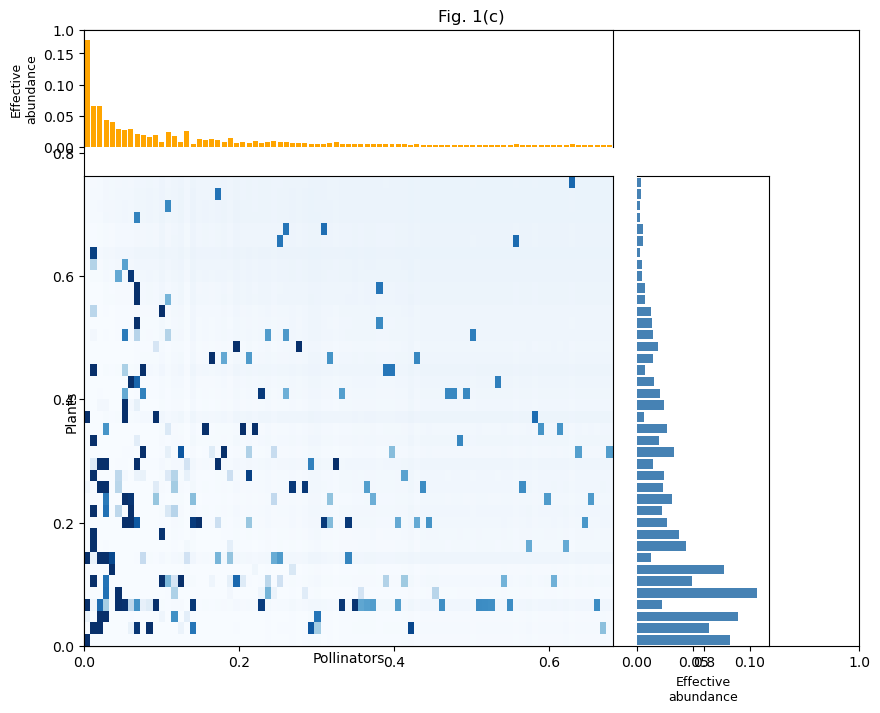

In [28]:
figure_1_c(samples)

### Inferred Species Abundances

The Bayesian model infers effective abundance parameters for each species:  
- $ \sigma_i $ for plant species $ i $, and  
- $ \tau_j $ for pollinator species $ j $.

These parameters represent the relative abundance or visibility of each species, marginalized over all posterior samples. In practice, they also absorb other observation-related effects (e.g., detectability, observer bias, spatial dominance), and should be interpreted as *effective* rather than purely biological abundance.

The bar plots above show the posterior means of these parameters, averaged across all MCMC samples:

- The first plot shows the inferred abundances of each plant species ($ \sigma $),
- The second shows the inferred abundances of each pollinator species ($ \tau $).

While the original study compares these estimates to measured floral abundances (Figure 3d), such empirical abundance data were not available for the `M_PL_019` dataset used here. Nonetheless, the inferred abundances provide valuable ecological insight into species prominence and interaction potential within the network.

In [29]:
def plot_subset_interaction_matrices(M, M_tilde, edge_prob, n_p, n_a, subset_n_p, subset_n_a):
    """
    Plots subsets of interaction and edge probability matrices for randomly selected 
    plants and pollinators.

    Args:
        M: Full input interaction matrix.
        M_tilde: Full posterior predictive interaction matrix.
        edge_prob: Full edge probability matrix.
        n_p: Total number of plants.
        n_a: Total number of pollinators.
        subset_n_p: Number of plants to include in the subset plot.
        subset_n_a: Number of pollinators to include in the subset plot.
    """

    if subset_n_p > n_p:
        print(f"Warning: subset_n_p ({subset_n_p}) is larger than n_p ({n_p}). Using n_p instead.")
        subset_n_p = n_p
    if subset_n_a > n_a:
        print(f"Warning: subset_n_a ({subset_n_a}) is larger than n_a ({n_a}). Using n_a instead.")
        subset_n_a = n_a
    if subset_n_p <= 0 or subset_n_a <= 0:
        print("Error: Subset sizes must be positive.")
        return

    # --- Randomly select indices for plants and pollinators ---
    # Use replace=False to ensure unique indices
    plant_indices = np.sort(np.random.choice(range(n_p), size=subset_n_p, replace=False))
    pollinator_indices = np.sort(np.random.choice(range(n_a), size=subset_n_a, replace=False))

    # --- Extract the sub-matrices using the selected indices ---
    # np.ix_ is useful for creating index arrays for sub-matrix selection
    ixgrid = np.ix_(plant_indices, pollinator_indices)
    M_sub = M[ixgrid]
    M_tilde_sub = M_tilde[ixgrid]
    edge_prob_sub = edge_prob[ixgrid]

    # --- Define original labels for the selected subset ---
    plant_labels = plant_indices + 1  # Original identifiers (1-based)
    pollinator_labels = pollinator_indices + 1 # Original identifiers (1-based)

    # --- Helper function for plotting a single matrix subset ---
    def plot_single_subset(matrix_sub, title, colorbar_label, cmap, vmin=None, vmax=None):
        plt.figure(figsize=(6, max(2, 6 * subset_n_p / subset_n_a))) # Adjust aspect ratio
        plt.title(title)
        
        # Use imshow for potentially non-uniform grids or pcolormesh if preferred
        # Using pcolormesh as in the original example
        plt.pcolormesh(matrix_sub, cmap=cmap, vmin=vmin, vmax=vmax)
        
        cb = plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
        cb.ax.get_yaxis().labelpad = 15
        cb.set_label(colorbar_label, rotation=270)
        
        # Set ticks based on the subset size and labels based on original IDs
        plt.yticks(np.arange(subset_n_p) + 0.5, plant_labels)
        plt.xticks(np.arange(subset_n_a) + 0.5, pollinator_labels, rotation=90) # Rotate if many labels
        
        plt.xlabel('Pollinator identifier')
        plt.ylabel('Plant identifier')
        plt.tight_layout() # Adjust layout to prevent labels overlapping

    # --- Plot the subsets ---
    plot_single_subset(M_sub, 'Input matrix (Subset)', 'Number of interactions', plt.cm.Blues)
    plot_single_subset(M_tilde_sub, 'Posterior predictive (Subset)', 'Number of interactions', plt.cm.Blues)
    plot_single_subset(edge_prob_sub, 'Edge probability (Subset)', 'Edge probability', plt.cm.Blues, vmin=0, vmax=1)

    plt.show()

In [30]:
edge_prob = pp.estimate_network(samples)

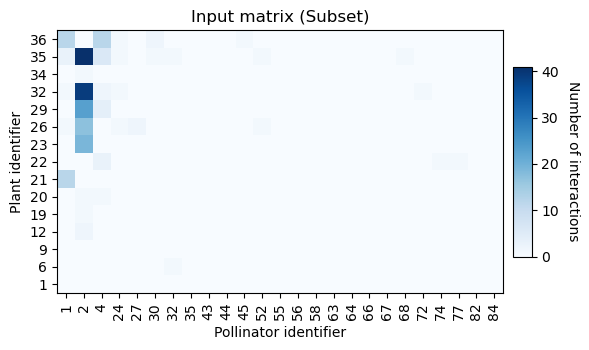

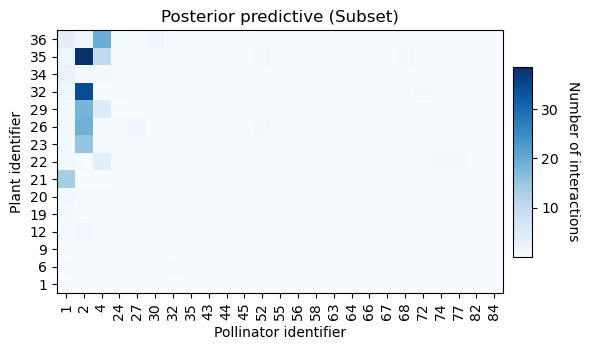

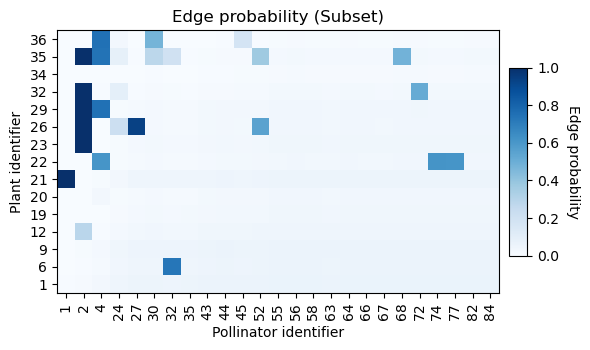

In [31]:
# Define the desired subset size
subset_plants = 15
subset_pollinators = 25

# Call the plotting function
plot_subset_interaction_matrices(
    M, 
    M_tilde, 
    edge_prob, 
    n_p, 
    n_a, 
    subset_plants, 
    subset_pollinators
)

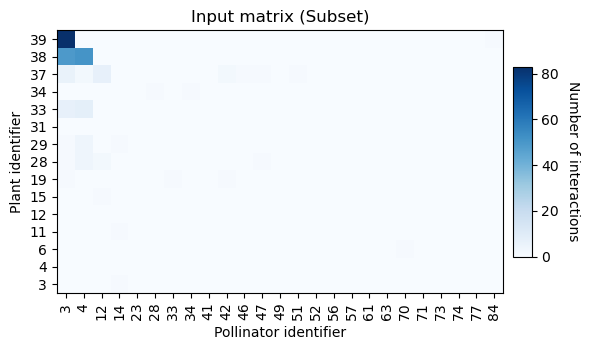

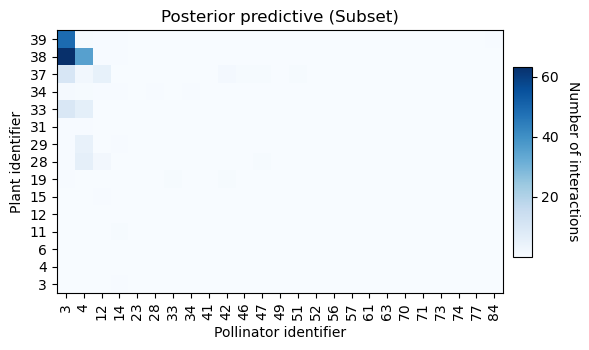

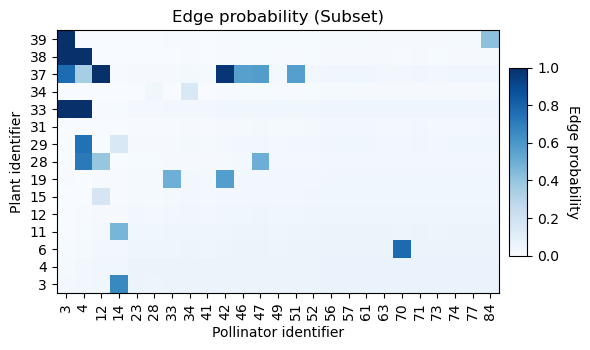

In [32]:
# Define the desired subset size
subset_plants = 15
subset_pollinators = 25

# Call the plotting function
plot_subset_interaction_matrices(
    M, 
    M_tilde, 
    edge_prob, 
    n_p, 
    n_a, 
    subset_plants, 
    subset_pollinators
)

The parameters themselves are contained in the `samples` object:

In [33]:
samples['rho']

array([0.05706737, 0.0609714 , 0.06933318, ..., 0.06116146, 0.07204774,
       0.06903865])

### Posterior Distribution of the Connectance Parameter $ \rho $

Figure 3a in the original study illustrates the posterior distribution of the connectance parameter $ \rho $, which represents the average prior probability that any given plant–pollinator interaction exists. This parameter controls the overall sparsity of the inferred network.

The histogram below shows the distribution of $ \rho $ values sampled from the posterior distribution using Monte Carlo methods. Each sample corresponds to a different realization of the model, conditioned on the observed data matrix $ M $.

The shape of the distribution summarizes our uncertainty about global network density. A sharply peaked distribution would indicate high certainty, while a broader spread (as observed here) reflects variability in inferred network sparsity across posterior samples. This is especially expected in real-world aggregated data sets, where species richness and interaction heterogeneity are high.

So we can, for example, visualize posterior distributions as:

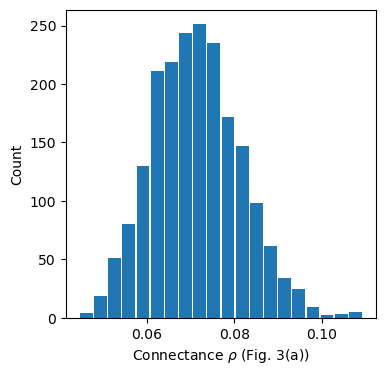

In [34]:
plt.figure(figsize=(4,4))
plt.hist(samples['rho'], density=False, bins=20, rwidth=0.9);

plt.xlabel(r'Connectance $\rho$ (Fig. 3(a))')
plt.ylabel('Count')
plt.show()

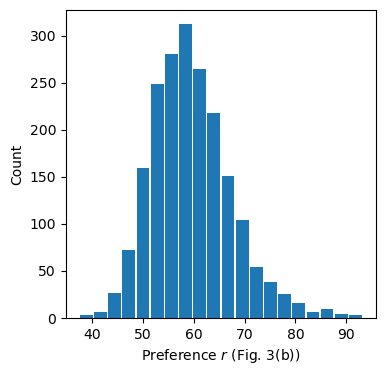

In [35]:
plt.figure(figsize=(4,4))
plt.hist(samples['r'], density=False, bins=20, rwidth=0.9);

plt.xlabel(r'Preference $r$ (Fig. 3(b))')
plt.ylabel('Count')
plt.show()

In [14]:
def estimate_networks(samples):
    """Return the matrix of edge probabilities P(B_ij=1)."""
    return samples['Q']

In [15]:
from scipy.stats import bernoulli

In [16]:
edge_probability_matrices=estimate_networks(samples)

for i in range(edge_probability_matrices.shape[0]):
    edge_probability_matrices[i,:,:]=bernoulli.rvs(edge_probability_matrices[i,:,:])

In [17]:
def compute_nodf(matrix):
    """Computes NODF (Nestedness metric based on Overlap and Decreasing Fill)
    for a binary incidence matrix. Assumes shape (plants × pollinators)."""
    matrix = matrix.astype(int)
    rows, cols = matrix.shape

    # Sort rows and columns by decreasing degree
    row_degrees = matrix.sum(axis=1)
    col_degrees = matrix.sum(axis=0)

    row_order = np.argsort(-row_degrees)
    col_order = np.argsort(-col_degrees)

    M_sorted = matrix[row_order, :][:, col_order]

    # Row NODF
    nodf_rows = 0
    pairs_rows = 0
    for i in range(rows):
        for j in range(i + 1, rows):
            ki, kj = M_sorted[i].sum(), M_sorted[j].sum()
            if ki == kj or kj == 0:
                continue
            overlap = np.logical_and(M_sorted[i], M_sorted[j]).sum()
            nodf_rows += overlap / min(ki, kj)
            pairs_rows += 1

    # Column NODF
    nodf_cols = 0
    pairs_cols = 0
    for i in range(cols):
        for j in range(i + 1, cols):
            ki, kj = M_sorted[:, i].sum(), M_sorted[:, j].sum()
            if ki == kj or kj == 0:
                continue
            overlap = np.logical_and(M_sorted[:, i], M_sorted[:, j]).sum()
            nodf_cols += overlap / min(ki, kj)
            pairs_cols += 1

    # Combine
    total_pairs = pairs_rows + pairs_cols
    if total_pairs == 0:
        return 0.0
    return (nodf_rows + nodf_cols) / total_pairs

In [18]:
nodf_values=np.zeros(edge_probability_matrices.shape[0])

for i in range(edge_probability_matrices.shape[0]):
    nodf_values[i] = compute_nodf(edge_probability_matrices[i,:,:])

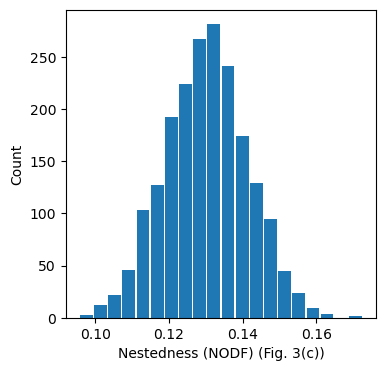

In [41]:
plt.figure(figsize=(4,4))
plt.hist(nodf_values, density=False, bins=20, rwidth=0.9);

plt.xlabel("Nestedness (NODF) (Fig. 3(c))")
plt.ylabel('Count')
plt.show()

In [19]:

print(np.mean(nodf_values))

0.130475807047633


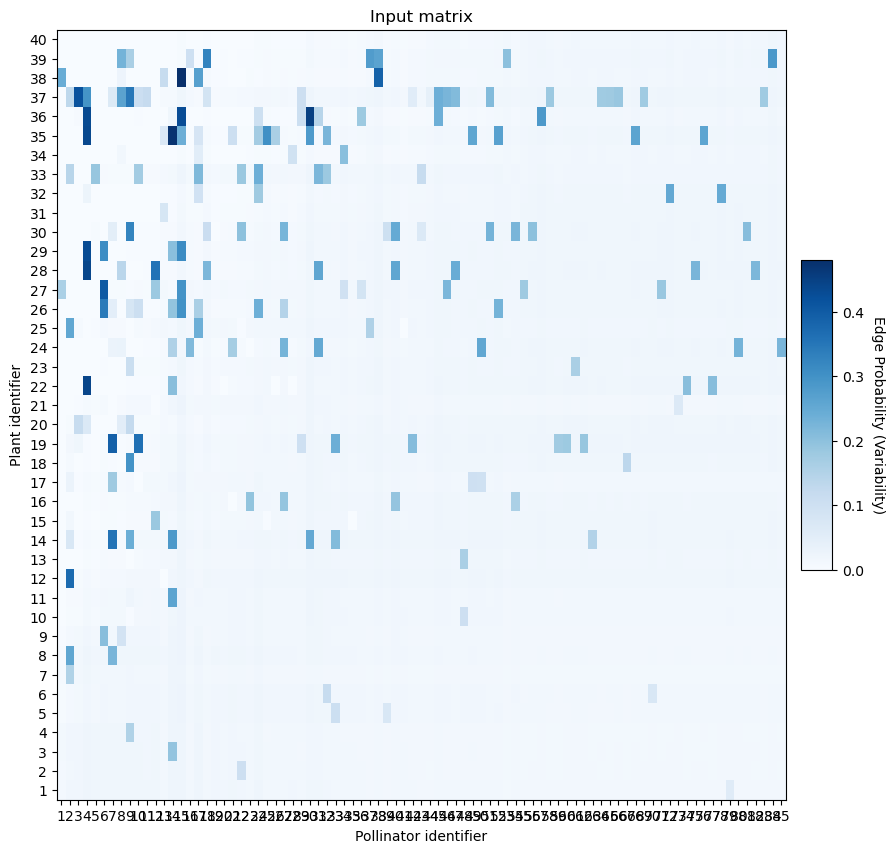

In [21]:
edge_probability_matrices=estimate_networks(samples)

plt.figure(figsize=(10,10))
plt.title('Input matrix')
plt.pcolormesh(edge_probability_matrices.std(axis=0), cmap=plt.cm.Blues)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Edge Probability (Variability)', rotation=270)
plt.yticks(np.array(range(n_p)) + 0.5, range(1, n_p + 1))
plt.xticks(np.array(range(n_a)) + 0.5, range(1, n_a + 1))
plt.xlabel('Pollinator identifier')
plt.ylabel('Plant identifier')
plt.show()

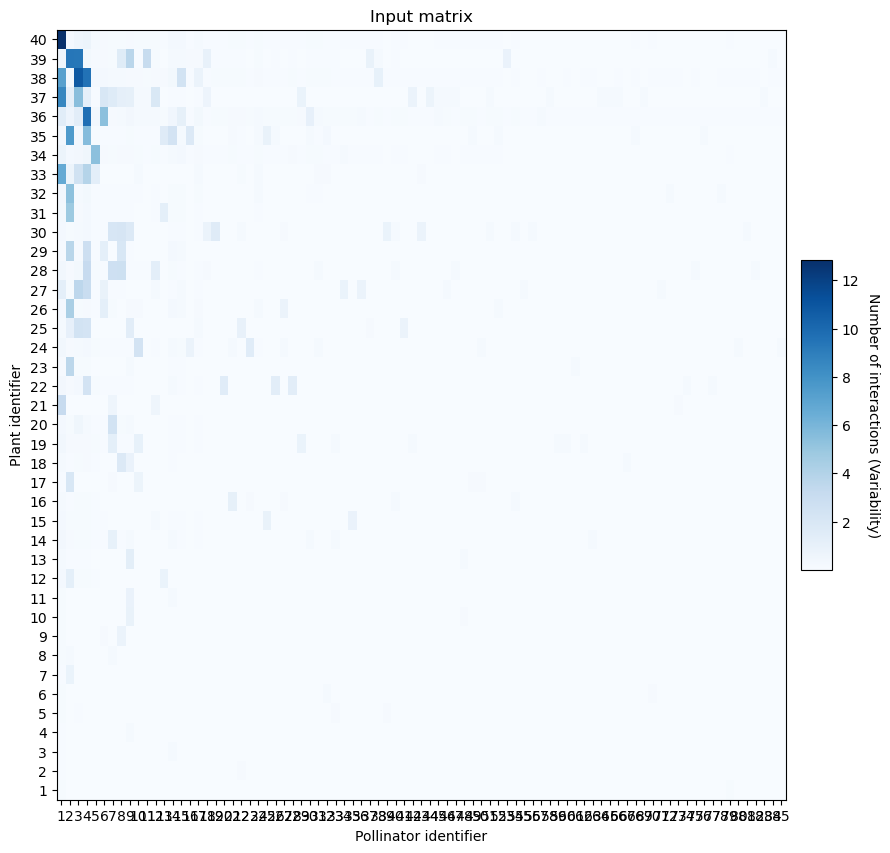

In [22]:
plt.figure(figsize=(10,10))
plt.title('Input matrix')
plt.pcolormesh(posterior_samples.std(axis=0), cmap=plt.cm.Blues)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Number of interactions (Variability)', rotation=270)
plt.yticks(np.array(range(n_p)) + 0.5, range(1, n_p + 1))
plt.xticks(np.array(range(n_a)) + 0.5, range(1, n_a + 1))
plt.xlabel('Pollinator identifier')
plt.ylabel('Plant identifier')
plt.show()

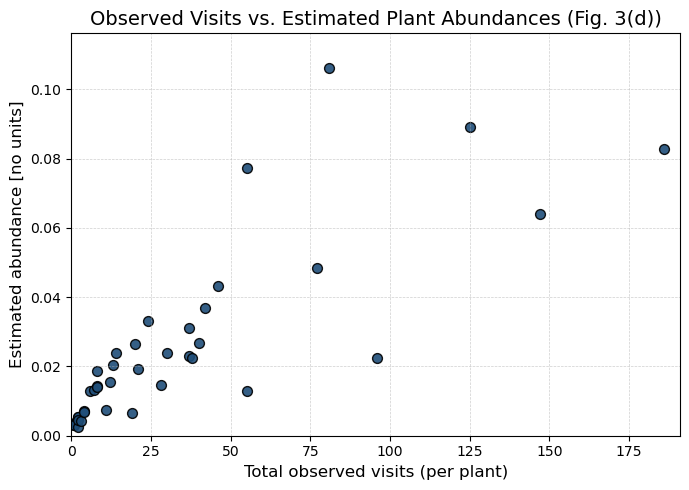

In [42]:
# Compute observed total visits per plant (row sums of the M matrix)
observed_visits = M.sum(axis=1)  # M is the observed plant–pollinator interaction matrix

# Compute posterior mean of sigma for each plant
sigma_mean = samples['sigma'].mean(axis=0)

# Plotting
fig, ax = plt.subplots(figsize=(7, 5))

ax.scatter(
    observed_visits,
    sigma_mean,
    s=50,
    color="#1f4e79",
    edgecolor="black",
    alpha=0.9
)

# Axis labeling and formatting
ax.set_title("Observed Visits vs. Estimated Plant Abundances (Fig. 3(d))", fontsize=14)
ax.set_xlabel("Total observed visits (per plant)", fontsize=12)
ax.set_ylabel("Estimated abundance [no units]", fontsize=12)
ax.set_xlim(0, observed_visits.max() + 5)
ax.set_ylim(0, max(sigma_mean) + 0.01)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
ax.tick_params(axis='both', labelsize=10)

plt.tight_layout()
plt.show()

In [43]:
samples


For the full summary use 'print(fit)'

Inference for Stan model: plant_pol_e215d9f28a31a5a7790444e1b0d7f7ff.
4 chains, each with iter=2500; warmup=2000; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
C          205.1     nan  24.98 160.03 187.89  203.0 222.01 258.54    nan    nan
r          59.62     nan   7.81  47.02  54.05  58.91  64.24  77.76    nan    nan
sigma[1]  3.7e-3     nan 3.3e-3 3.4e-4 1.5e-3 2.8e-3 4.9e-3   0.01    nan    nan
sigma[2]  3.3e-3     nan 2.8e-3 3.2e-4 1.3e-3 2.5e-3 4.5e-3   0.01    nan    nan
sigma[3]  3.1e-3     nan 3.0e-3 2.6e-4 1.2e-3 2.3e-3 4.1e-3   0.01    nan    nan
sigma[4]  3.0e-3     nan 2.7e-3 2.9e-4 1.2e-3 2.2e-3 3.8e-3 9.7e-3    nan    nan
sigma[5]  5.4e-3     nan 3.8e-3 8.3e-4 2.8e-3 4.6e-3 7.0e-3   0.02    nan    nan
sigma[6]  5.5e-3     nan 4.0e-3 8.5e-4 2.7e-3 4.4e-3 7.4e-3   0.02    nan    nan
sigma[7]  2.5e-3     nan 2.2e-3 4.4e-4 1.3e-

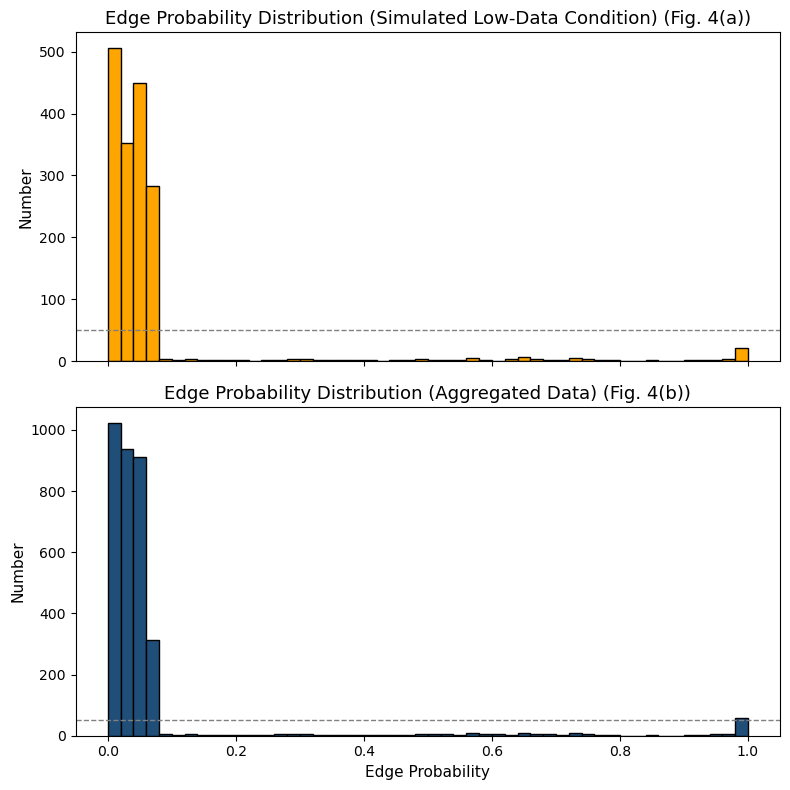

In [47]:
# Function to subsample plant rows
def subsample_matrix(M, frac=0.5):
    n_rows = M.shape[0]
    selected = np.random.choice(n_rows, int(n_rows * frac), replace=False)
    return M[selected, :], selected

# Function to compute average edge probabilities
def average_edge_probs(M, C_samples, r_samples, rho_samples, sigma_samples, tau_samples):
    n_samples = len(C_samples)
    n_plants, n_pollinators = M.shape
    Q_sum = np.zeros((n_plants, n_pollinators))

    for k in range(n_samples):
        sigma_tau = np.outer(sigma_samples[k], tau_samples[k])
        mu0 = C_samples[k] * sigma_tau
        log_numerator = np.log(rho_samples[k] + 1e-12) + M * np.log(1 + r_samples[k] + 1e-12) - mu0 * r_samples[k]
        log_numerator = np.clip(log_numerator, -700, 700)
        numerator = np.exp(log_numerator)
        denominator = (1 - rho_samples[k]) + numerator
        Q = numerator / (denominator + 1e-12)
        Q = np.nan_to_num(Q, nan=0.0, posinf=1.0, neginf=0.0)
        Q_sum += np.clip(Q, 0, 1)

    return Q_sum / n_samples

# Simulate a low-data condition by subsampling rows
M_sub, sub_idx = subsample_matrix(M, frac=0.5)
sigma_samples_sub = [sigma[sub_idx] for sigma in samples['sigma']]

# Compute posterior edge probabilities
Q_sub = average_edge_probs(M_sub, samples['C'], samples['r'], samples['rho'], sigma_samples_sub, samples['tau'])
Q_full = average_edge_probs(M, samples['C'], samples['r'], samples['rho'], samples['sigma'], samples['tau'])

# Flatten for plotting
qvals_sub = Q_sub.flatten()
qvals_full = Q_full.flatten()

# Plot histograms
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# Figure 4a – subsampled (orange bars)
ax1.hist(qvals_sub, bins=50, color="orange", edgecolor='black')
ax1.axhline(50, color='gray', linestyle='--', linewidth=1)
ax1.set_title("Edge Probability Distribution (Simulated Low-Data Condition) (Fig. 4(a))", fontsize=13)
ax1.set_ylabel("Number", fontsize=11)

# Figure 4b – full data (blue bars)
ax2.hist(qvals_full, bins=50, color="#1f4e79", edgecolor='black')
ax2.axhline(50, color='gray', linestyle='--', linewidth=1)
ax2.set_title("Edge Probability Distribution (Aggregated Data) (Fig. 4(b))", fontsize=13)
ax2.set_xlabel("Edge Probability", fontsize=11)
ax2.set_ylabel("Number", fontsize=11)

plt.tight_layout()
plt.show()